# Customising the spaCy pipeline

This section introduces you to customising the spaCy pipeline, that is, determining just what spaCy does with text and how.

After reading this section, you should know how to:

 - examine and modify the spaCy pipeline
 - process texts efficiently
 - add custom attributes to spaCy objects
 - save processed texts on disk
 - merge noun phrases and named entities

Let's start by importing the spaCy library and the displacy module for drawing dependency trees.

In [1]:
# Import the spaCy library and the displacy module
from spacy import displacy
import spacy

2022-08-28 07:32:02.441466: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-28 07:32:02.441524: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


We then import a language model for English.

In [2]:
# Load a small language model for English and assign it to the variable 'nlp'
nlp = spacy.load('en_core_web_sm')

# Call the variable to examine the object
nlp

## Modifying spaCy pipelines

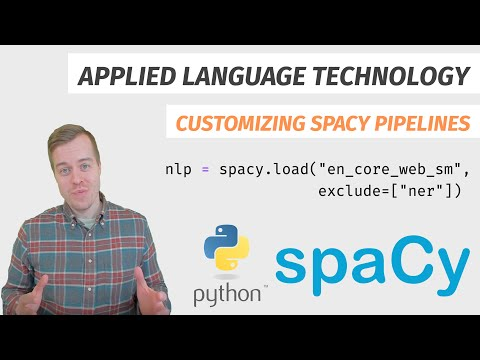

In [3]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('F4SJJQF49b0', height=350, width=600)

Let's start by examining the spaCy *Language* object in more detail.

The *Language* object is a essentially pipeline that applies some language model to text by performing the tasks that the model has been trained to do.

The tasks performed depend on the components present in the pipeline.

We can examine the components of a pipeline using the `pipeline` attribute of a *Language* object.

In [4]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f8143a599a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f81437b7400>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f8143a4a660>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f81437b4280>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f81437acfc0>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f8143a4a890>)]

This returns a spaCy *SimpleFrozenList* object, which consists of Python _tuples_ with two items: 

 1. component names, e.g. `tagger`, 
 2. the actual components that perform different tasks, e.g. `spacy.pipeline.tok2vec.Tok2Vec`.

Components such as `tagger`, `parser`, `ner` and `lemmatizer` should already be familiar to you from the [previous section](../part_ii/03_basic_nlp.ipynb).

There are, however, two components present in `nlp.pipeline` that we have not yet encountered. 

 - `tok2vec` maps *Tokens* to their numerical representations. We will learn about these representations in [Part III](../part_iii/04_embeddings.ipynb).

 - `attribute_ruler` applies user-defined rules to *Tokens*, such as matches for a given linguistic pattern, and adds this information to the *Token* as an attribute if requested. We will explore the use of matchers in [Part III](../part_iii/03_pattern_matching.ipynb).

Note also that the list of components under `nlp.pipeline` does not include a *Tokenizer*, because all texts must be tokenized for any kind of processing to take place. Hence the *Tokenizer* is placed under the `tokenizer` attribute of a *Language* object rather than the `pipeline` attribute.

It is important to understand that all pipeline components come with a computational cost. 

If you do not need the output, you should not include a component in the pipeline, because the time needed to process the data will be longer.

To exclude a component from the pipeline, provide the `exclude` argument with a *string* or a *list* that contain the names of the components to exclude when initialising a *Language* object using the `load()` function. 

In [5]:
# Load a small language model for English, but exclude named entity
# recognition ('ner') and syntactic dependency parsing ('parser'). 
nlp = spacy.load('en_core_web_sm', exclude=['ner', 'parser'])

Let's examine the `pipeline` attribute again.

In [6]:
# Examine the active components under the Language object 'nlp'
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f814372aa00>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f8142366fa0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f81421d6480>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f81421d6300>)]

As the output shows, the `ner` and `parser` components are no longer included in the pipeline.

A *Language* object also provides a `analyze_pipes()` method for an overview of the pipeline components and their interactions. By setting the attribute `pretty` to `True`, spaCy prints out a table that lists the components and the annotations they produce. 

In [7]:
# Analyse the pipeline and store the analysis under 'pipe_analysis'
pipe_analysis = nlp.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component         Assigns       Requires   Scores      Retokenizes
-   ---------------   -----------   --------   ---------   -----------
0   tok2vec           doc.tensor                           False      
                                                                      
1   tagger            token.tag                tag_acc     False      
                                                                      
2   attribute_ruler                                        False      
                                                                      
3   lemmatizer        token.lemma              lemma_acc   False      

✔ No problems found.


The `analyze_pipes()` method returns a Python *dictionary*, which contains the same information presented in the table above.

You can use this dictionary to check that no problems are found before processing large volumes of data.

Problem reports are stored in a dictionary under the key `problems`.

We can access the values under the `problems` key by placing the name of the key in brackets `[ ]`.

In [8]:
# Examine the value stored under the key 'problems'
pipe_analysis['problems']

{'tok2vec': [], 'tagger': [], 'attribute_ruler': [], 'lemmatizer': []}

This returns a dictionary with component names as keys, whose values contain lists of problems.

In this case, the lists are empty, because no problems exist.

We can, however, easily write a piece of code that checks if this is indeed the case.

To do so, we loop over the `pipe_analysis` dictionary, using the `items()` method to fetch the key/value pairs.

We assign the keys and values to variables `component_name` and `problem_list`, respectively.

We then use the `assert` statement with the `len()` function and the *comparison operator* `==` to check that the length of the list is 0.

If this assertion is not true, that is, if the length of `problem_list` is more than 0, which would indicate the presence of a problem, Python will raise an `AssertionError` and stop.

In [9]:
# Loop over the key/value pairs in the dictionary. Assign the key and
# value pairs to the variables 'component_name' and 'problem_list'.
for component_name, problem_list in pipe_analysis['problems'].items():
    
    # Use the assert statement to check the list of problems; raise Error if necessary.
    assert len(problem_list) == 0, f"There is a problem with {component_name}: {problem_list}!"

In this case, we also print an error message using a *formatted string*. The error message is separated from the assertion by a comma. 

Note that the quotation marks are preceded by the character `f`. By declaring that this string can be formatted, we can insert variables into the string! 

The variable names inserted into the string are surrounded by curly braces `{}`. If an error message is raised, these parts of the string will be populated using the values currently stored under the variables `component_name` and `problem_list`.

If no problems are encountered, the loop will pass silently.

## Processing texts efficiently

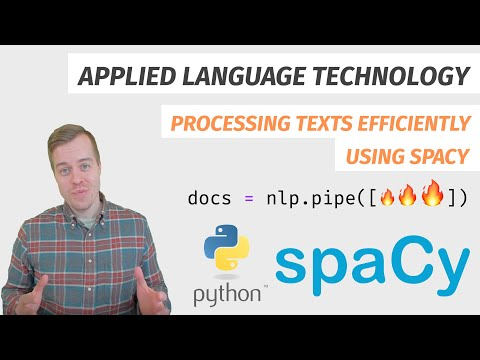

In [10]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('00yChd449uI', height=350, width=600)

When working with high volumes of data, processing the data as efficiently as possible is highly desirable.

To illustrate the best practices of processing texts efficiently using spaCy, let's define a toy example that consists of a Python list with three example sentences from English Wikipedia.

In [11]:
# Initialise the language model again, because we need dependency
# parsing for the following sections.
nlp = spacy.load('en_core_web_sm')

# Define a list of example sentences
sents = ["On October 1, 2009, the Obama administration went ahead with a Bush administration program, increasing nuclear weapons production.", 
         "The 'Complex Modernization' initiative expanded two existing nuclear sites to produce new bomb parts.", 
         "The administration built new plutonium pits at the Los Alamos lab in New Mexico and expanded enriched uranium processing at the Y-12 facility in Oak Ridge, Tennessee."]

# Call the variable to examine output
sents

['On October 1, 2009, the Obama administration went ahead with a Bush administration program, increasing nuclear weapons production.',
 "The 'Complex Modernization' initiative expanded two existing nuclear sites to produce new bomb parts.",
 'The administration built new plutonium pits at the Los Alamos lab in New Mexico and expanded enriched uranium processing at the Y-12 facility in Oak Ridge, Tennessee.']

This returns a list with three sentences.

spaCy _Language_ objects have a specific method, `pipe()`, for processing texts stored in a Python list.

The `pipe()` method has been optimised for this purpose, processing texts in _batches_ rather than individually, which makes this method faster than processing each list item separately using a `for` loop.

The `pipe()` method takes a _list_ as input and returns a Python _generator_ named `pipe`.

In [12]:
# Feed the list of sentences to the pipe() method
docs = nlp.pipe(sents)

# Call the variable to examine the output
docs

<generator object Language.pipe at 0x7f81420fe5f0>

Generators are Python objects that contain other objects. When called, a generator object will yield objects contained within itself. 

To retrieve all objects in a generator, we must cast the output into another object type, such as a list. 

You can think of the list as a data structure that is able to collect the generator output for examination.

In [13]:
# Cast the pipe generator into a list
docs = list(docs)

# Call the variable to examine the output
docs

[On October 1, 2009, the Obama administration went ahead with a Bush administration program, increasing nuclear weapons production.,
 The 'Complex Modernization' initiative expanded two existing nuclear sites to produce new bomb parts.,
 The administration built new plutonium pits at the Los Alamos lab in New Mexico and expanded enriched uranium processing at the Y-12 facility in Oak Ridge, Tennessee.]

This gives us a list of spaCy _Doc_ objects for further processing.

## Adding custom attributes to spaCy objects

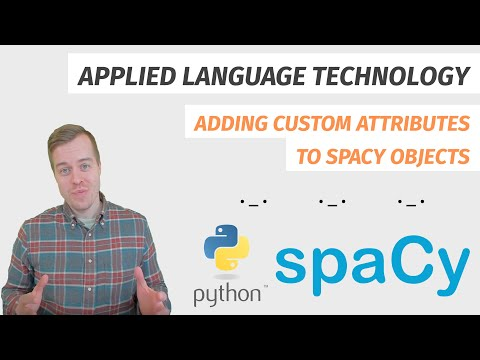

In [14]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('oWsuCwCW29g', height=350, width=600)

The [previous section](../part_ii/03_basic_nlp.ipynb) showed how linguistic annotations produced by spaCy can be accessed through their attributes.

In addition, spaCy allows setting custom attributes to *Doc*, *Span* and *Token* objects. These attributes can be used, for example, to store additional information about the texts that are being processed.

If you are working with texts that contain information about language users, you can incorporate this information directly into the spaCy objects.

To exemplify, custom attributes can be added directly to the *Doc* object using the `set_extension()` method.

Because these attributes are added to all *Doc* objects instead of individual *Doc* objects, we must first import the generic *Doc* object from spaCy's `tokens` module.

In [15]:
# Import the Doc object from the 'tokens' module in spaCy
from spacy.tokens import Doc

We can now use the `set_extension()` method to add two attributes, `age` and `location` to the *Doc* object.

We use the `default` argument to set a default value for both variables. For this purpose, we use the `None` keyword in Python.

In [16]:
# Add two custom attributes to the Doc object, 'age' and 'location'
# using the set_extension() method.
Doc.set_extension("age", default=None)
Doc.set_extension("location", default=None)

The `age` and `location` attributes are now added to the *Doc* object.

Unlike attributes such as `sents` or `heads`, the custom attributes are placed under an attribute that consists of the underscore character `_`, e.g. `Doc._.age`.

To exemplify how these custom attributes can be set for actual *Doc* objects, let's define a toy example that consists of a Python dictionary.

The `sents_dict` dictionary contains three keys: `0`, `1` and `2`. The values under these keys consist of dictionaries with three keys: `age`, `location` and `text`.

This also exemplifies how Python data structures and formats are often nested within one another: a dictionary can easily include another dictionary, which contain both integer and string objects as keys and values.

In [17]:
# Create a dictionary whose values consist of another dictionary
# with three keys: 'age', 'location' and 'text'.
sents_dict = {0: {"age": 23, 
                  "location": "Helsinki", 
                  "text": "The Senate Square is by far the most important landmark in Helsinki."
                 },
              1: {"age": 35, 
                  "location": "Tallinn", 
                  "text": "The Old Town, for sure."
                 },
              2: {"age": 58, 
                  "location": "Stockholm", 
                  "text": "Södermalm is interesting!"
                 }
             }

Let's loop over the `sents_dict` dictionary to process the examples and add the custom attributes to the resulting *Doc* objects.

In [18]:
# Set up a placeholder list to hold the processed texts
docs = []

# Loop over pairs of keys and values in the 'sents_dict' dictionary.
# Note that the key/value pairs are available under the items() method.
# We refer to these keys and values as 'key' and 'data', respectively.
# This means that we used the variable 'data' to refer to the nested
# dictionary.
for key, data in sents_dict.items():
    
    # Retrieve the value under the key 'text' from the nested dictionary.
    # Feed this text to the language model under 'nlp' and assign the 
    # result to the variable 'doc'.
    doc = nlp(data['text'])
    
    # Retrieve the values for 'age' and 'location' from the nested dictionary.
    # Assign these values into the custom attributes defined for the Doc object.
    # Note that custom attributes reside under a pseudo attribute consisting of
    # an underscore '_'!  
    doc._.age = data['age']
    doc._.location = data['location']
    
    # Append the current Doc object under 'doc' to the list 'docs'
    docs.append(doc)

This provides a list of *Doc* objects, which is assigned under the variable `docs`.

Let's loop over the `docs` list and print out the *Doc* and its custom attributes.

In [19]:
# Loop over each Doc object in the list 'docs'
for doc in docs:
    
    # Print each Doc and the 'age' and 'location' attributes
    print(doc, doc._.age, doc._.location)

The Senate Square is by far the most important landmark in Helsinki. 23 Helsinki
The Old Town, for sure. 35 Tallinn
Södermalm is interesting! 58 Stockholm


The custom attributes can be used, for example, to filter the data.

One efficient way to filter the data is to use a Python *list comprehension*.

A comprehension evaluates the contents of an existing list and populates a new list based on some criteria.

A list comprehension is like a `for` loop that is declared on the fly using brackets `[]`, which are used to designate lists in Python.

In this case, the list comprehension consists of three components:
 
 - The first reference to `doc` on the left hand-side of the `for` statement defines what is stored in the new list. We store whatever is stored in the original list, that is, a *Doc* object.
 - The `for` .. `in` statements operate just like in a `for` loop. We loop over items in the list `docs` and refer to each item using the variable `doc`.
 - The third statement beginning with `if` defines a conditional: we only include *Doc* objects whose custom attribute `age` has a value below 40.

In [42]:
# Use a list comprehension to filter the Docs for those whose
# 'age' attribute has a value under 40.
#第一句话可以理解为for item in sth，keep it if……
under_forty = [doc for doc in docs if doc._.get('age') < 40]

# Call the variable to examine the output
under_forty

TypeError: '<' not supported between instances of 'NoneType' and 'int'

This returns a list with only two *Doc* objects that fill the designated criteria, that is, their `age` attribute has a value below 40.

## Writing processed texts to disk

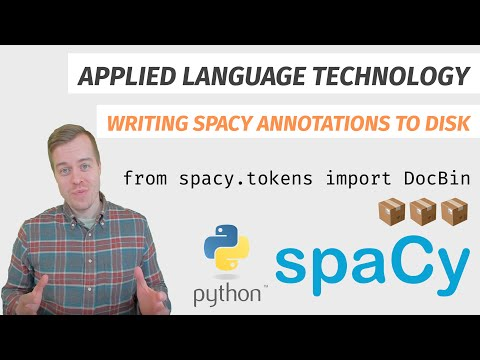

In [21]:
# Run this cell to view a YouTube video related to this topic
from IPython.display import YouTubeVideo
YouTubeVideo('zKvW8o-1wmk', height=350, width=600)

When working with high volumes of texts, you should first ensure that the pipeline produces the desired results by using a smaller number of texts. 

Once everything works as desired, you can proceed to process all of the text and save the result, because processing large volumes of text takes time and resources.

spaCy provides a special object type named *DocBin* for storing *Doc* objects that contain linguistic annotations from spaCy.

In [22]:
# Import the DocBin object from the 'tokens' module in spacy
from spacy.tokens import DocBin

Creating a *DocBin* object is easy. To populate the *DocBin* object with *Docs* upon creation, use the `docs` argument to pass a Python generator or list that contains *Doc* objects.

In this case, we add the three *Docs* stored under the variable `docs` to the *DocBin*.

In [23]:
# Initialize a DocBin object and add Docs from 'docs'
docbin = DocBin(docs=docs)

If you have added custom attributes to *Docs*, *Spans*, or *Tokens*, you must also set the `store_user_data` argument to `True`, e.g. `DocBin(docs=docs, store_user_data=True)`.  

We can easily verify that all three *Docs* made it into the *DocBin* by examining the output of its `__len__()` method.

In [24]:
# Get the number of Docs in the DocBin
docbin.__len__()

3

The `add()` method allows adding additional *Doc* objects to the *DocBin* if necessary.

In [25]:
# Define and feed a string object the language model under 'nlp'
# and add the resulting Doc to the DocBin object 'docbin'
docbin.add(nlp("Yet another Doc object."))

# Verify that the Doc was added; length should be now 4
docbin.__len__()

4

Once you have populated a *DocBin* object with your data, you must write the object to a disk for storage.

This can be achieved using the `to_disk()` method of the *DocBin*.

The `to_disk()` method takes a single argument, `path`, which defines a path to the file in which the *DocBin* object should be written.

Let's write the *DocBin* object into a file named `docbin.spacy` in the `data` directory.

In [26]:
# Write the DocBin object to disk
docbin.to_disk(path='data/docbin.spacy')

To load a *DocBin* object from disk, you need to first initialise an empty *DocBin* object using `DocBin()` and then use the `from_disk()` method to load the actual *DocBin* object.

In [27]:
# Initialise a new DocBin object and use the 'from_disk' method to
# load the data from the disk. Assign the result to the variable
# 'docbin_loaded'.
docbin_loaded = DocBin().from_disk(path='data/docbin.spacy')

# Call the variable to examine the output
docbin_loaded

Finally, to access the *Doc* object stored within the *DocBin*, you must use the `get_docs()` method.

The `get_docs()` method takes a single argument, `vocab`, which takes the vocabulary of a *Language* object as input. 

The vocabulary, which is stored under the `vocab` attribute of a *Language* object, is needed to reconstruct the information stored in the *DocBin*.

In [28]:
# Use the 'get_docs' method to retrieve Doc objects from the DocBin,
# passing the vocabulary under 'nlp.vocab' to reconstruct the data.
# Cast the resulting generator object into a list for examination.
docs_loaded = list(docbin_loaded.get_docs(nlp.vocab))

# Call the variable to examine the output
docs_loaded

[The Senate Square is by far the most important landmark in Helsinki.,
 The Old Town, for sure.,
 Södermalm is interesting!,
 Yet another Doc object.]

This returns a list that contains the four *Doc* objects added to the *DocBin* above.

To summarise, you should ideally process the texts once, write them to disk and load them for further analysis.

## Simplifying output for noun phrases and named entities 

### Merging noun phrases

The [previous section](../part_ii/03_basic_nlp.ipynb) described how tasks such as part-of-speech tagging and dependency parsing involve making predictions about individual *Tokens* and their properties, such as their part-of-speech tags or syntactic dependencies.

Occasionally, however, it may be more beneficial to operate with larger linguistic units instead of individual *Tokens*, such as noun phrases that consist of multiple *Tokens*.

spaCy provides access to noun phrases via the attribute `noun_chunks` of a *Doc* object.

Let's print out the noun chunks in each _Doc_ object contained in the list `docs`.

In [29]:
# Define the first for-loop over the list 'docs'
# The variable 'doc' refers to items in the list
for doc in docs:
    
    # Loop over each noun chunk in the Doc object
    for noun_chunk in doc.noun_chunks:
        
        # Print noun chunk
        print(noun_chunk)

The Senate Square
the most important landmark
Helsinki
The Old Town
Södermalm


These two `for` loops return several noun phrases that consist of multiple _Tokens_.

For merging noun phrases into a single *Token*, spaCy provides a function named `merge_noun_tokens` that can be added to the pipeline stored in a *Language* object using the `add_pipe` method.

In [30]:
# Add component that merges noun phrases into single Tokens
nlp.add_pipe('merge_noun_chunks')

<function spacy.pipeline.functions.merge_noun_chunks(doc: spacy.tokens.doc.Doc) -> spacy.tokens.doc.Doc>

In this case, we do not need to reassign the *Language* object under `nlp` to the same variable to update its contents. The `add_pipe` method adds the component to the *Language* object automatically. 

We can verify that the component was added successfully by examining the `pipeline` attribute under the *Language* object `nlp`. 

In [31]:
# List the pipeline components
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f8140d709a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f8140bea340>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f81422f36d0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f8140bc8b40>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f8140bf1c80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f81422f3740>),
 ('merge_noun_chunks',
  <function spacy.pipeline.functions.merge_noun_chunks(doc: spacy.tokens.doc.Doc) -> spacy.tokens.doc.Doc>)]

As you can see, the final tuple in the list consists of the `merge_noun_chunks` function.

To examine the consequences of adding this function to the pipeline, let's process the three example sentences again using the `pipe()` method of the _Language_ object `nlp`.

We overwrite the previous results stored under the same variable by assigning the output to the variable `docs`.

Note that we also cast the result into a list by wrapping the _Language_ object and the `pipe()` method into a `list()` function.

In [32]:
# Apply the Language object 'nlp' to the list of sentences under 'sents'
docs = list(nlp.pipe(sents))

# Call the variable to examine the output
docs

[On October 1, 2009, the Obama administration went ahead with a Bush administration program, increasing nuclear weapons production.,
 The 'Complex Modernization' initiative expanded two existing nuclear sites to produce new bomb parts.,
 The administration built new plutonium pits at the Los Alamos lab in New Mexico and expanded enriched uranium processing at the Y-12 facility in Oak Ridge, Tennessee.]

Superficially, everything remains the same: the list contains three *Doc* objects. 

However, if we loop over the *Tokens* in the first *Doc* object in the list, which can be accessed using brackets at position zero, e.g. `[0]`, we can see that the noun phrases are now merged and tagged using the label `NOUN`.

In [33]:
# Loop over Tokens in the first Doc object in the list
for token in docs[0]:
    
    # Print out the Token and its part-of-speech tag
    print(token, token.pos_)

On ADP
October PROPN
1 NUM
, PUNCT
2009 NUM
, PUNCT
the Obama administration NOUN
went VERB
ahead ADV
with ADP
a Bush administration program NOUN
, PUNCT
increasing VERB
nuclear weapons production NOUN
. PUNCT


Tagging noun phrases using the label `NOUN` is a reasonable approximation, as their head words are nouns.

As rendering the syntactic parse using displacy shows, merging the noun phrases simplifies the parse tree.

In [34]:
displacy.render(docs[0], style='dep')

Although the noun phrases are now represented by single *Tokens*, the noun chunks are still available under the `noun_chunks` attribute of the *Doc* object.

As shown below, spaCy stores noun chunks as *Spans*, whose `start` attribute determines the index of the Token where the *Span* starts, while the `end` attribute determines where the *Span* has ended.

This information is useful, if the syntactic analysis reveals patterns that warrant a closer examination of the noun chunks and their structure.

In [35]:
# Loop over the noun chunks in the first Doc object [0] in the list 'docs'
for noun_chunk in docs[0].noun_chunks:
    
    # Print out noun chunk, its type, the Token where the chunks starts and where it ends
    print(noun_chunk, type(noun_chunk), noun_chunk.start, noun_chunk.end)

October <class 'spacy.tokens.span.Span'> 1 2
the Obama administration <class 'spacy.tokens.span.Span'> 6 7
a Bush administration program <class 'spacy.tokens.span.Span'> 10 11
nuclear weapons production <class 'spacy.tokens.span.Span'> 13 14


### Merging named entities

Named entities can be merged in the same way as noun phrases by providing `merge_entities` to the `add_pipe()` method of the *Language* object.

Let's start by removing the `merge_noun_chunks` function from the pipeline.

The `remove_pipe()` method can be used to remove a pipeline component.

In [36]:
# Remove the 'merge_noun_chunks' function from the pipeline under 'nlp'
nlp.remove_pipe('merge_noun_chunks')

# Process the original sentences again
docs = list(nlp.pipe(sents))

The method returns a tuple containing the name of the removed component (in this case, a function) and the component itself.

We can verify this by calling the `pipeline` attribute of the *Language* object `nlp`.

In [37]:
nlp.pipeline

[('tok2vec', <spacy.pipeline.tok2vec.Tok2Vec at 0x7f8140d709a0>),
 ('tagger', <spacy.pipeline.tagger.Tagger at 0x7f8140bea340>),
 ('parser', <spacy.pipeline.dep_parser.DependencyParser at 0x7f81422f36d0>),
 ('attribute_ruler',
  <spacy.pipeline.attributeruler.AttributeRuler at 0x7f8140bc8b40>),
 ('lemmatizer',
  <spacy.lang.en.lemmatizer.EnglishLemmatizer at 0x7f8140bf1c80>),
 ('ner', <spacy.pipeline.ner.EntityRecognizer at 0x7f81422f3740>)]

Finally, let's add the `merge_entities` component to the pipeline under `nlp`.

In [38]:
# Add the 'merge_entities' function to the pipeline
nlp.add_pipe('merge_entities')

# Process the data again
#加了一个，想要它发挥作用，就reload一次
docs = list(nlp.pipe(sents))

Let's examine the result by looping over the _Tokens_ in the third _Doc_ object.

In [39]:
# Loop over Tokens in the third Doc object in the list
for token in docs[2]:
    
    # Print out the Token and its part-of-speech tag
    print(token, token.pos_)

The DET
administration NOUN
built VERB
new ADJ
plutonium NOUN
pits NOUN
at ADP
the DET
Los Alamos PROPN
lab NOUN
in ADP
New Mexico PROPN
and CCONJ
expanded VERB
enriched ADJ
uranium NOUN
processing NOUN
at ADP
the DET
Y-12 NUM
facility NOUN
in ADP
Oak Ridge PROPN
, PUNCT
Tennessee PROPN
. PUNCT


Named entities that consist of multiple *Tokens*, as exemplified by place names such as "Los Alamos" and "New Mexico", have been merged into single *Tokens*.

This section should have given you an idea of how to tailor spaCy to fit your needs, how to process texts efficiently and how to save the result to disk.

The [following section](../part_ii/05_evaluating_nlp.ipynb) introduces you to evaluating the performance of language models. 